## MACHINE LEARNING ASSIGNMENT 1
#### Regression task
#### Student: Vishnevskiy Mark

#### 1. Import libraries

In [229]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

#### 2. Load data

In [230]:
bitrate_df = pd.read_csv('./bitrate/bitrate_train.csv')
bitrate_dft = pd.read_csv('./bitrate/bitrate_test.csv')
bitrate_df.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0


#### 3. Explore data

In [231]:
# import pandas_profiling

# profileReport = pandas_profiling.profile_report.ProfileReport(bitrate_df)
# profileReport.to_file('bitrate_report.html')

#### 4. Preprocessing

In [232]:
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

def preprocess_data(bitrate_df, bitrate_df_test = None):
    
    # removing outliers
    bitrate_df = bitrate_df[(np.abs(stats.zscore(bitrate_df)) < 3).all(axis=1)]
    
    # splitting into features and target to avoid target scaling
    y_train = bitrate_df['target']
    x_train = bitrate_df.drop(['target'], axis=1)

    # scaling data
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
    
    # same, but for test data (fitted on train data)
    if (not bitrate_dft is None):
        y_test = bitrate_dft['target']
        x_test = bitrate_dft.drop(['target'], axis=1)
        x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
    return x_train, y_train, x_test, y_test


In [233]:
x_train, y_train, x_test, y_test = preprocess_data(bitrate_df, bitrate_dft)

x_train = x_train.drop(['bitrate_mean','bitrate_std'], axis=1)
x_test = x_test.drop(['bitrate_mean','bitrate_std'], axis=1)

#### 5. Feature selection

In [234]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(x_train, y_train)


In [235]:
coefs = np.array(ridge.coef_)
num_of_features = 8
indexes = sorted(range(len(coefs)), key=lambda k: -coefs[k])[:num_of_features]
selected_features = [x_train.columns.to_list()[i] for i in indexes]
print(selected_features)

['dropped_frames_std', 'fps_mean', 'dropped_frames_max', 'fps_std', 'rtt_std', 'rtt_mean', 'dropped_frames_mean']


#### 6. Data visualization

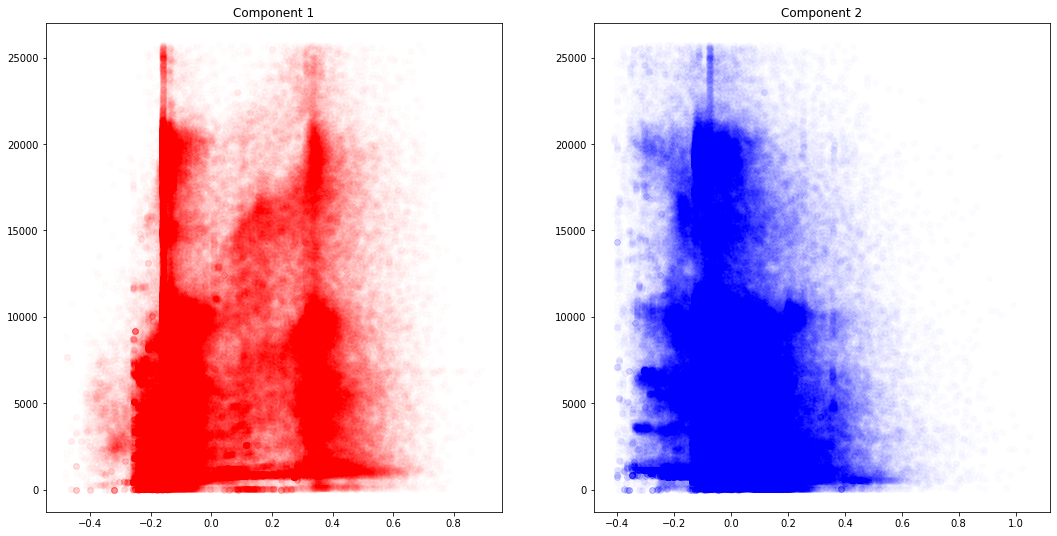

In [236]:
from sklearn.decomposition import PCA

dim_reducer = PCA(n_components=2)
x_train_2d = dim_reducer.fit_transform(x_train)

plt.figure(figsize=(18, 9))
plt.subplot(121)
plt.title('Component 1')
plt.plot(x_train_2d[:,0], y_train, 'ro', alpha=0.01)
plt.subplot(122)
plt.title('Component 2')
plt.plot(x_train_2d[:,1], y_train, 'bo', alpha=0.01)
plt.show()

#### 7. Machine learning

In [237]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn import metrics

regressors = [LinearRegression(), Ridge(), BayesianRidge()]
for rg in regressors:
    rg.fit(x_train, y_train)

predictions = [rg.predict(x_test) for rg in regressors]
predictions_train = [rg.predict(x_train) for rg in regressors]


In [238]:
y_test = y_test.values

In [239]:
results = {'Model':['LinReg', 'Ridge', 'BayesianRidge']}
results['Mean Absolute Error'] = [metrics.mean_absolute_error(y_test, y_pred) for y_pred in predictions]
results['Mean Squared Error'] = [metrics.mean_squared_error(y_test, y_pred) for y_pred in predictions]
results['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred)) for y_pred in predictions]
results['Root Squared'] = [np.sqrt(abs(metrics.r2_score(y_test, y_pred))) for y_pred in predictions]
measures = pd.DataFrame(data=results)

results_train = {'Model':['LinReg', 'Ridge', 'BayesianRidge']}
results_train['Mean Absolute Error'] = [metrics.mean_absolute_error(y_train, y_pred) for y_pred in predictions_train]
results_train['Mean Squared Error'] = [metrics.mean_squared_error(y_train, y_pred) for y_pred in predictions_train]
results_train['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_train, y_pred)) for y_pred in predictions_train]
results_train['Root Squared'] = [np.sqrt(abs(metrics.r2_score(y_train, y_pred))) for y_pred in predictions_train]
measures_train = pd.DataFrame(data=results_train)

In [240]:
measures

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Root Squared
0,LinReg,4485.921033,4.076966e+07,6385.112467,0.378506
1,Ridge,4483.772023,3.868925e+07,6220.068606,0.291424
2,BayesianRidge,4484.982508,3.883732e+07,6231.959874,0.298463


In [241]:
measures_train

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Root Squared
0,LinReg,4251.012759,2.795126e+07,5286.895189,0.254703
1,Ridge,4251.030729,2.795144e+07,5286.912092,0.254691
2,BayesianRidge,4251.026368,2.795142e+07,5286.910426,0.254692
